# Measurement Incompatibility Testing

In [ ]:
# Make sure to load your IBM Q token before running the below block

In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq.managed import IBMQJobManager

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import matplotlib.pyplot as plt
import numpy as np

# custom code
import context
from device_independent_test import incompatible_measurement
from device_independent_test import quantum_communicator

In [2]:
def bb84_states():
    # Alice's half of the circuit
    # creates 0,1,+,-
    qc = QuantumCircuit(4)
    qc.x(1) # create 1
    qc.h(2) # create +
    qc.x(3) # create -
    qc.h(3) # ^
    return qc

In [3]:
def measure_circuit(y):
    # Bob's measurement circuit
    # measure in either pi/4 or 3pi/4 basis
    assert y == 0 or y == 1, "Bob's input should be 0 or 1"
    qc = QuantumCircuit(4)
    theta = -1.0*(np.pi/4 + 0.5*y*np.pi)
    qc.u3(theta,0,0,range(0,4))
    #qc.u3(theta,0,0,1)
    #qc.u3(theta,0,0,2)
    #qc.u3(theta,0,0,3)
    qc.measure_all()
    return qc

In [4]:
qc = bb84_states() + measure_circuit(0)
qc.draw()

┌───────────────┐                                   ░ ┌─┐         
   q_0: ┤ U3(-pi/4,0,0) ├───────────────────────────────────░─┤M├─────────
        └─────┬───┬─────┘┌───────────────┐                  ░ └╥┘┌─┐      
   q_1: ──────┤ X ├──────┤ U3(-pi/4,0,0) ├──────────────────░──╫─┤M├──────
              ├───┤      ├───────────────┤                  ░  ║ └╥┘┌─┐   
   q_2: ──────┤ H ├──────┤ U3(-pi/4,0,0) ├──────────────────░──╫──╫─┤M├───
              ├───┤      └─────┬───┬─────┘┌───────────────┐ ░  ║  ║ └╥┘┌─┐
   q_3: ──────┤ X ├────────────┤ H ├──────┤ U3(-pi/4,0,0) ├─░──╫──╫──╫─┤M├
              └───┘            └───┘      └───────────────┘ ░  ║  ║  ║ └╥┘
meas_0: ═══════════════════════════════════════════════════════╩══╬══╬══╬═
                                                                  ║  ║  ║ 
meas_1: ══════════════════════════════════════════════════════════╩══╬══╬═
                                                                     ║  ║ 
meas_2: ═════════════════════════════════════════════════════════════╩══╬═
                                                                        ║ 
meas_3: ════════════════════════════════════════════════════════════════╩═

In [136]:
# OUTDATED CODE
# SEE CELL BELOW FOR BATCH JOB

from qiskit.tools.monitor import *
def run_job(qc):
    # runs test on all inputs
    # run cicuits in one batch
    #job_manager = IBMQJobManager()
    #job_set = job_manager.run([qc_0, qc_1], backend=provider.get_backend('ibmq_qasm_simulator'), name='msrincom_test')
    #job_monitor(job_set)
    #job_set.error_message()
    job = execute(qc, backend=provider.get_backend('ibmq_qasm_simulator'), shots=1000)
    job_monitor(job)
    return job
qc_0 = bb84_states() + measure_circuit(0)
job = run_job(qc_0)
job.result().get_counts(qc_0)
plot_histogram(job.result().get_counts(qc_0))


SyntaxError: positional argument follows keyword argument (<ipython-input-136-b0fe4b8dea3e>, line 12)

In [78]:
from qiskit.tools.monitor import *
def run_jobs(qc):
    # run cicuits in one batch
    job_manager = IBMQJobManager()
    job_set = job_manager.run(qc, backend=provider.get_backend('ibmq_qasm_simulator'), name='msrincom_test')
    job_set.error_messages()
    return job_set
qc_0 = bb84_states() + measure_circuit(0)
qc_1 = bb84_states() + measure_circuit(1)
managed_job = run_jobs([qc_0,qc_1])


In [83]:
result_0 = managed_job.job(0)[0].result()
result_1 = managed_job.job(1)[0].result()
#managed_job.job(0)[0].error_message()
result_0.get_counts(qc_0)

{'1011': 85,
 '0000': 17,
 '0001': 2,
 '1001': 23,
 '1111': 20,
 '1100': 18,
 '1010': 524,
 '0010': 104,
 '0100': 4,
 '0111': 3,
 '1101': 4,
 '0110': 10,
 '1110': 94,
 '1000': 105,
 '0011': 11}

Job Status: job has successfully run


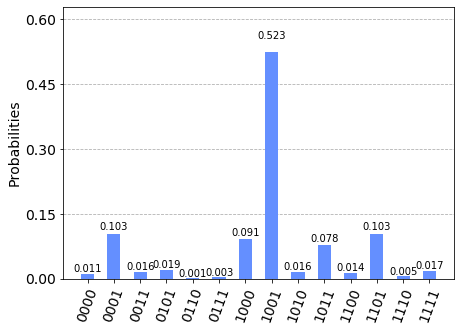

In [33]:
qc_1 = bb84_states() + measure_circuit(1)
job2 = run_job(qc_1)
job2.result().get_counts(qc_1)
plot_histogram(job2.result().get_counts(qc_1))

In [61]:
counts = job2.result().get_counts(qc_1)
print(counts)

# 2x4 matrix for probabilities
# row for x
# column for y
bins = (2,4)
bins = np.zeros(bins)

# iterate over dictionary
for state in counts:
    for i in range(0,4):
        r = int(state[i])
        c = 3 - i
        bins[r,c] += counts[state]
print(bins)
# convert bins to probibilities
probs = bins / 1000.0
print(probs)

{'1011': 78, '0000': 11, '0001': 103, '1001': 523, '1111': 17, '1100': 14, '0101': 19, '1010': 16, '0111': 3, '1101': 103, '0110': 1, '1110': 5, '1000': 91, '0011': 16}
[[138. 864. 838. 153.]
 [862. 136. 162. 847.]]
[[0.138 0.864 0.838 0.153]
 [0.862 0.136 0.162 0.847]]


In [132]:
from qiskit.quantum_info import Statevector

In [133]:
qc = bb84_states()
state = Statevector.from_instruction(qc)
print(state)
real_state = [0,0,0.5+0.j,0,0,0,0.5,0,0,0,-0.5,0,0,0,-0.5,0]
print(state.data)
print(state.data == real_state)
print(state.data[2])
error = abs(state.data-real_state)
epsilon = 1.0E-4
any(x>epsilon for x in error)

Statevector([ 0. +0.j,  0. +0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,
              0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j,
              0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j],
            dims=(2, 2, 2, 2))
[ 0. +0.j  0. +0.j  0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0.5+0.j  0. +0.j
  0. +0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j]
[ True  True False  True  True  True False  True  True  True False  True
  True  True False  True]
(0.4999999999999999+0j)


False

# Communicator Testing

┌───────────────┐ ░ ┌─┐         
   q_0: ┤ U3(-pi/4,0,0) ├─░─┤M├─────────
        ├───────────────┤ ░ └╥┘┌─┐      
   q_1: ┤ U3(-pi/4,0,0) ├─░──╫─┤M├──────
        ├───────────────┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ U3(-pi/4,0,0) ├─░──╫──╫─┤M├───
        ├───────────────┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ U3(-pi/4,0,0) ├─░──╫──╫──╫─┤M├
        └───────────────┘ ░  ║  ║  ║ └╥┘
meas_0: ═════════════════════╩══╬══╬══╬═
                                ║  ║  ║ 
meas_1: ════════════════════════╩══╬══╬═
                                   ║  ║ 
meas_2: ═══════════════════════════╩══╬═
                                      ║ 
meas_3: ══════════════════════════════╩═

4


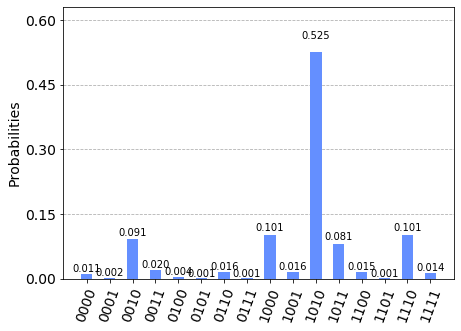

In [5]:
communicator = quantum_communicator.LocalCommunicator([provider.get_backend('ibmq_qasm_simulator')])
print(communicator)
pre_operations = bb84_states()
post_operations = (QuantumCircuit(4),measure_circuit(0))
display(post_operations[1].draw())
size = max(post_operations[0].num_qubits,post_operations[1].num_qubits)
print(size)
counts = communicator.run_and_transmit("nothing","nothing",pre_operations,post_operations,1000)
plot_histogram(counts)

In [4]:
communicator = quantum_communicator.LocalCommunicator([provider.get_backend('ibmq_qasm_simulator')])
pre_operations = [bb84_states(),bb84_states()]
post_operations = [[QuantumCircuit(4),QuantumCircuit(4)],[measure_circuit(0),QuantumCircuit(4)]]
counts = communicator.batch_run_and_transmit("","",pre_operations,post_operations,1000)
print(counts)

[{'1000': 99, '1001': 18, '0011': 23, '1111': 11, '1100': 9, '0010': 92, '0001': 5, '1010': 531, '0110': 12, '0000': 17, '0111': 4, '1011': 88, '0100': 6, '1101': 2, '1110': 83}, {'NO MEASUREMENT': 0}, {'1000': 94, '1001': 18, '0011': 18, '1111': 15, '1100': 17, '0010': 93, '0001': 2, '1010': 507, '0110': 22, '0000': 21, '0111': 3, '1011': 80, '0100': 2, '1101': 2, '1110': 106}, {'NO MEASUREMENT': 0}, {'1000': 77, '1001': 18, '0011': 23, '1111': 28, '1100': 19, '0010': 91, '0001': 1, '1010': 517, '0110': 15, '0000': 18, '0111': 2, '1011': 100, '0100': 1, '1101': 5, '1110': 85}, {'NO MEASUREMENT': 0}, {'0110': 12, '0111': 3, '1011': 97, '0100': 1, '1110': 95, '1000': 85, '1001': 16, '0011': 14, '1111': 12, '1100': 16, '0010': 111, '0001': 1, '1010': 517, '0000': 17, '0101': 1, '1101': 2}, {'NO MEASUREMENT': 0}]


In [9]:
test = [[1,2,3],[4,5,6],[7,8,9]]
print(test)
print(test[0][2])
print(test[1][0])

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]
3
4


In [4]:
communicator = quantum_communicator.LocalCommunicator([provider.get_backend('ibmq_qasm_simulator')])
pre_operations = [bb84_states(),QuantumCircuit(4),bb84_states()]
#post_operations = [[QuantumCircuit(4),QuantumCircuit(4),QuantumCircuit(4)],[measure_circuit(0),QuantumCircuit(4),measure_circuit(1)]]
post_operations = [[QuantumCircuit(4),measure_circuit(0)],[QuantumCircuit(4),QuantumCircuit(4)],[QuantumCircuit(4),QuantumCircuit(4)]]
count0 = communicator.run_and_transmit("","",pre_operations[0],post_operations[0],1000)
#count1 = communicator.run_and_transmit("","",pre_operations[0],[post_operations[0][0],post_operations[1][0]],1000)
#count2 = communicator.run_and_transmit("","",pre_operations[0],[post_operations[0][0],post_operations[1][0]],1000)
count1 = communicator.run_and_transmit("","",pre_operations[1],post_operations[1],1000)
count2 = communicator.run_and_transmit("","",pre_operations[2],post_operations[2],1000)
print(count2)
#print(count1)
#print(count2)

┌───────────────┐                                  
q_0: ┤ U3(-pi/4,0,0) ├──────────────────────────────────
     └─────┬───┬─────┘┌───────────────┐                 
q_1: ──────┤ X ├──────┤ U3(-pi/4,0,0) ├─────────────────
           ├───┤      ├───────────────┤                 
q_2: ──────┤ H ├──────┤ U3(-pi/4,0,0) ├─────────────────
           ├───┤      └─────┬───┬─────┘┌───────────────┐
q_3: ──────┤ X ├────────────┤ H ├──────┤ U3(-pi/4,0,0) ├
           └───┘            └───┘      └───────────────┘

q_0: 
     
q_1: 
     
q_2: 
     
q_3:

q_0: ──────────
     ┌───┐     
q_1: ┤ X ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘

{'0': 0}


In [6]:
print(count0)

{'0010 0010': 93, '1011 1011': 91, '1111 1111': 18, '0100 0100': 4, '1000 1000': 80, '1110 1110': 86, '0111 0111': 2, '0011 0011': 16, '0110 0110': 12, '0001 0001': 5, '1001 1001': 14, '1100 1100': 22, '1101 1101': 2, '1010 1010': 541, '0000 0000': 14}


In [9]:
circuits = [bb84_states()+measure_circuit(0),bb84_states()+measure_circuit(1),bb84_states()]
job_manager = IBMQJobManager()
job_set = execute(circuits,backend=provider.get_backend('ibmq_qasm_simulator'),shots=1000)

# retrieve and return counts
counts = []
for i in range (0,len(circuits)):
    if job_set.result().data(circuits[i]) == {}:
        counts.append({"NO_MEASURMENT":0})
    else:
        counts.append(job_set.result().get_counts(circuits[i]))
    
print(counts)

[{'1010': 557, '0111': 1, '0001': 5, '0011': 15, '0100': 1, '0000': 16, '0010': 91, '1110': 84, '1000': 91, '1111': 19, '1001': 13, '1101': 5, '0110': 13, '1100': 14, '1011': 75}, {'1010': 15, '0001': 109, '0011': 14, '0100': 3, '0000': 14, '0010': 2, '1110': 2, '1000': 82, '1111': 17, '0101': 16, '1001': 521, '1101': 102, '1100': 8, '1011': 95}, {'NO MEASURMENT': 0}]


<bound method Result.data of Result(backend_name='ibmq_qasm_simulator', backend_version='0.5.2', date=datetime.datetime(2020, 6, 26, 20, 48, 1, 855894), header=Obj(backend_name='ibmq_qasm_simulator', backend_version='0.1.547'), job_id='5ef65efeb74e4b00126aaad6', metadata={'max_memory_mb': 257936, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken': 0.006904338}, qobj_id='196f4b89-25b4-4421-8ff3-18e7d5ec893f', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=17, 0x1=2, 0x2=100, 0x3=22, 0x4=2, 0x6=15, 0x7=4, 0x8=81, 0x9=13, 0xa=539, 0xb=90, 0xc=16, 0xd=1, 0xe=87, 0xf=11)), header=Obj(clbit_labels=[['meas', 0], ['meas', 1], ['meas', 2], ['meas', 3]], creg_sizes=[['meas', 4]], memory_slots=4, n_qubits=4, name='circuit2105', qreg_sizes=[['q', 4]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3]]), meas_level=<MeasLevel.CLASSIFIED: 2>, metadata={'measure_sampling': True, 'method': 'statevector', 'parallel_shots': 1, 'parallel_state_update': 16}, seed_simulator

In [13]:
result_1 = job_set.job(1)[0].result()
counts = result_2.get_counts(circuits[1])

In [14]:
results = job_set.results()
print(results)

In [31]:
counts = results.data(QuantumCircuit(2))
print(counts)

IBMQJobManagerJobNotFound: 'Unable to find the job for experiment circuit2102.'

In [22]:
# Build a thousand circuits.
from qiskit.circuit.random import random_circuit
circs = []
for _ in range(10):
    circs.append(random_circuit(n_qubits=5, depth=4))

# Use Job Manager to break the circuits into multiple jobs.
job_manager = IBMQJobManager()
job_set_foo = job_manager.run(circs, backend=provider.get_backend('ibmq_qasm_simulator') , name='foo')

/Users/louisschatzki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: random_circuit keyword argument n_qubits is deprecated and replaced with num_qubits.
  """


In [23]:
testresults = job_set_foo.results()
test5 = testresults.get_counts(5)

/Users/louisschatzki/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/managed/managedjob.py:187: UserWarning: Unable to retrieve job result for experiments 0-9, job ID=5ef65c6a4faf630014c031c9: 'Unable to retrieve result for job 5ef65c6a4faf630014c031c9. Job has failed. Use job.error_message() to get more details.' 
  self.start_index, self.end_index, self.job.job_id(), err))


IBMQManagedResultDataNotAvailable: 'Result data for experiment 5 is not available.'